## Importing Libraries

In [1]:
!pip install spacy pandas numpy scikit-learn wordcloud langdetect

import spacy
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_data = pd.read_csv('twitter_analysis.csv')
train_data = train_data.sample(frac = 0.05)
train_data.head()

,sentiment,text
1445872,4,@MsLaurenLondon One day I'm going to work with...
767921,0,@kjannfischer yep - died as I was backing out ...
528160,0,@MichelleDK Yea :S My poor small car is now li...
1565114,4,@peterfacinelli now following you to help! I h...
130128,0,Ugh monday yet again


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 1445872 to 626312
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  80000 non-null  int64 
 1   text       80000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [4]:
np.unique(train_data['sentiment'], return_counts = True)

(array([0, 4]), array([39945, 40055]))

In [5]:
X = train_data['text'].values
y = train_data['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, X_test.shape

((64000,), (16000,))

In [6]:
# Spacy's English model
!python -m spacy download en_core_web_sm

# Loading the Spacy model
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.3 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
# Cleaning text data
def preprocessing(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"@[A-Za-z0-9]+", ' ', sentence)
    sentence = re.sub(r"https?://[A-Za-z0-9./]+", ' ', sentence)
    sentence = sentence.replace('.', ' ')
    tokens = [token.text for token in nlp(sentence) 
              if not (token.is_stop or token.like_num 
                      or token.is_punct
                      or token.is_space
                      or len(token) == 1)]
    tokens = ' '.join(tokens)
    return tokens

In [8]:
X_train_cleaned = [preprocessing(tweet) for tweet in X_train]
X_test_cleaned = [preprocessing(tweet) for tweet in X_test]

## Wordcloud to spot common words

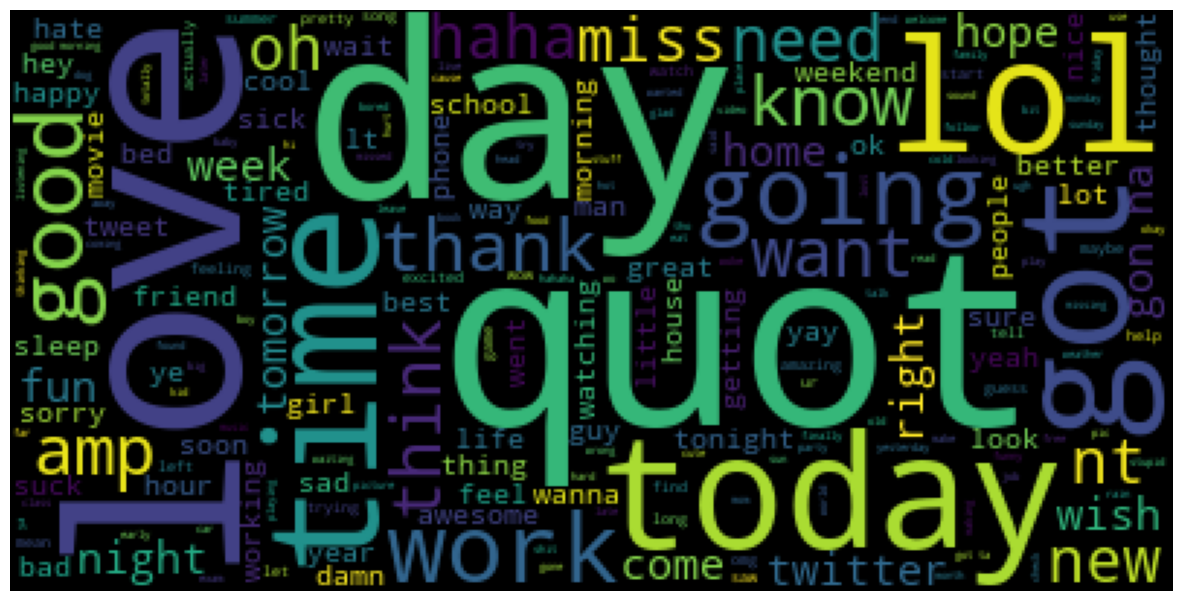

In [9]:
# Combine all cleaned training tweets in to a single string
texts = ' '.join(X_train_cleaned)

# Generate the word cloud
cloud = WordCloud().generate(texts)

# Display the word cloud

plt.figure(figsize = (15,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

## Detect Languages

In [10]:
# Detect the languages of the cleaned test tweets
languages = [detect(text) for text in X_test_cleaned if text]

# Display unique languages and their counts
unique_languages, counts = np.unique(languages, return_counts = True)

# Create a DataFrame to display the language counts
lang_data_dict = {'Language': unique_languages, 'Count': counts}
lang_dataframe = pd.DataFrame(lang_data_dict)
lang_dataframe.sort_values('Count', ascending = False)

,Language,Count
6,en,11336
0,af,943
24,so,540
17,nl,303
18,no,282
28,tl,271
3,cy,237
10,fr,218
8,et,212
4,da,196


## Lemmatization

In [11]:
def preprocessing_lemma(sentence):
    tokens = [token.lemma_ for token in nlp(sentence)]
    tokens = ' '.join(tokens)
    return tokens

X_train_cleaned_lemma = [preprocessing_lemma(tweet) for tweet in X_train_cleaned]
X_test_cleaned_lemma = [preprocessing_lemma(tweet) for tweet in X_test_cleaned]

vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train_cleaned_lemma)
X_train_tfidf_lemma = vectorizer.fit_transform(X_train_cleaned_lemma)
X_test_tfidf_lemma = vectorizer.transform(X_test_cleaned_lemma)

## Sentiment Analysis with TF-IDF Method

In [12]:
# Train a Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_tfidf_lemma, y_train)

# Predict the sentiments of the test tweets
predictions = classifier.predict(X_test_tfidf_lemma)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

# Display the evaluation results
print('Accuracy:', accuracy)
conf_matrix_df = pd.DataFrame(cm, index = ['Actual_0', 'Actual_4'], columns=['Predicted_0','Predicted_4'])
print(conf_matrix_df)
print(class_report)

Accuracy: 0.6869375
          Predicted_0  Predicted_4
Actual_0         5429         2575
Actual_4         2434         5562
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      8004
           4       0.68      0.70      0.69      7996

    accuracy                           0.69     16000
   macro avg       0.69      0.69      0.69     16000
weighted avg       0.69      0.69      0.69     16000

